## 1. Loading libraries

In [3]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings = warnings

In [4]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

In [79]:
# load libraries and modules
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, accuracy_score, classification_report

## 2. Train/ Test Split

In [83]:
path_t0_df = ROOT_DIR / 'data' / "t0.csv"  
t0_df = pd.read_csv(path_t0_df)
t0_df = t0_df.drop(columns=["SUBJECT_ID", "HADM_ID"])
t0_df

,IS_SEPSIS,ITEMID_50912,ITEMID_50931,ITEMID_51006,ITEMID_51221,ITEMID_51222,ITEMID_51244,ITEMID_51256,ITEMID_51274,ITEMID_51279,ITEMID_51301,AGE,GENDER_NUM
0,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,0,0
1,0,3.2,91.0,53.0,30.2,10.0,8.0,81.0,13.5,3.44,12.7,76,0
2,0,0.5,140.0,9.0,34.2,11.5,6.9,89.6,-999.0,3.80,9.7,47,1
3,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,0,0
4,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46043,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,78,0
46044,1,-999.0,-999.0,-999.0,36.4,12.4,8.1,85.1,-999.0,4.20,13.0,53,0
46045,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,47,0
46046,0,1.2,206.0,56.0,12.9,4.7,9.1,84.9,12.9,1.35,21.4,65,1


In [84]:
X_t0_train, X_t0_test, y_t0_train, y_t0_test = train_test_split(
    t0_df.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
    t0_df['IS_SEPSIS'],
    test_size=0.2,  # this means 20% test set
    stratify=t0_df['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

# If you want to get the train and test set as dataframes:
train_t0_df = pd.concat([X_t0_train, y_t0_train], axis=1)
test_t0_df = pd.concat([X_t0_test, y_t0_test], axis=1)

train_t0_df

,ITEMID_50912,ITEMID_50931,ITEMID_51006,ITEMID_51221,ITEMID_51222,ITEMID_51244,ITEMID_51256,ITEMID_51274,ITEMID_51279,ITEMID_51301,AGE,GENDER_NUM,IS_SEPSIS
4303,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,51,0,0
34546,2.3,86.0,42.0,27.6,9.3,5.4,91.3,-999.0,2.80,17.6,84,0,0
20956,0.7,112.0,9.0,38.6,13.2,3.6,94.1,12.7,4.49,12.0,82,1,0
9544,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,81,0,0
640,1.3,102.0,34.0,34.4,11.5,26.2,66.8,25.5,3.60,7.7,78,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16734,1.3,207.0,30.0,47.1,15.3,27.0,64.8,13.4,5.06,23.1,76,0,0
39431,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,67,1,0
41025,0.8,100.0,9.0,45.7,16.1,13.0,77.2,-999.0,5.20,11.2,55,0,0
2585,0.7,165.0,23.0,25.8,7.6,2.0,88.0,-999.0,3.22,19.6,55,1,0


In [85]:
# Counting the number of instance in each class in the training dataset
label_counts = train_t0_df["IS_SEPSIS"].value_counts()
label_proportions = label_counts / len(train_t0_df)*100

label_info = pd.DataFrame({'Count': label_counts, 'Proportion': label_proportions.map("{:.2f}%".format)})
print(label_info)

           Count Proportion
IS_SEPSIS                  
0          33168     90.04%
1           3670      9.96%


## 3. Features Scaling

In [86]:
t0_df.describe()

,IS_SEPSIS,ITEMID_50912,ITEMID_50931,ITEMID_51006,ITEMID_51221,ITEMID_51222,ITEMID_51244,ITEMID_51256,ITEMID_51274,ITEMID_51279,ITEMID_51301,AGE,GENDER_NUM
count,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000,46048.000000
mean,0.099635,-362.573592,-354.272694,-345.713560,-307.444499,-326.883647,-454.075482,-424.016524,-515.676417,-333.091724,-325.801632,52.979760,0.445079
std,0.299516,481.445342,580.048979,495.081338,487.532943,477.374816,507.126917,535.132736,507.112708,473.791189,476.906433,26.412991,0.496980
min,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000
25%,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,42.000000,0.000000
50%,0.000000,0.800000,91.000000,14.000000,31.600000,10.500000,3.300000,41.050000,-999.000000,3.480000,7.300000,61.000000,0.000000
75%,0.000000,1.200000,133.000000,25.000000,38.500000,13.000000,14.200000,79.600000,13.300000,4.280000,11.900000,73.000000,1.000000
max,1.000000,43.000000,2340.000000,274.000000,75.000000,24.400000,100.000000,99.000000,150.000000,8.970000,846.700000,89.000000,1.000000


In [87]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalisation
X_t0_train = scaler.fit_transform(X_t0_train)
X_t0_test = scaler.transform(X_t0_test)

## 4. Model Fitting

### 4.1 Logistic Regression

In [88]:
# Fitting a Logistic Regression Classifier
t0_lr = LogisticRegression(random_state=901)
t0_lr.fit(X_t0_train, y_t0_train)

/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=901)

In [89]:
# Looking at some predictions from the testing set
some_data = X_t0_test[:5]
some_labels = y_t0_test[:5]
print("Predictions:", t0_lr.predict(some_data))
print("Labels:", some_labels.values.flatten().tolist())

Predictions: [0 0 0 0 0]
Labels: [0, 0, 0, 1, 0]


In [90]:
t0_lr_predictions = t0_lr.predict(X_t0_test)
t0_lr_predicted_probabilities = t0_lr.predict_proba(X_t0_test)

In [91]:
# Computing the confusion matrix
print("Preliminary performance measures for Logistic Regression Classifier:\n")
print("Confusion Matrix: ")
print(confusion_matrix(y_t0_test, t0_lr_predictions))

# Computing the accuracy score
t0_lr_score = t0_lr.score(X_t0_test, y_t0_test)
print("\nAccuracy score: {:.4f}".format(t0_lr_score))

# Computing the root mean squared error (RMSE)
t0_lr_mse = mean_squared_error(y_t0_test, t0_lr_predictions) 
t0_lr_rmse = np.sqrt(t0_lr_mse)
print("RMSE: {:.4f}".format(t0_lr_rmse))

Preliminary performance measures for Logistic Regression Classifier:

Confusion Matrix: 
[[8292    0]
 [ 918    0]]

Accuracy score: 0.9003
RMSE: 0.3157


Performance measures on Logistic Regression Classifier:



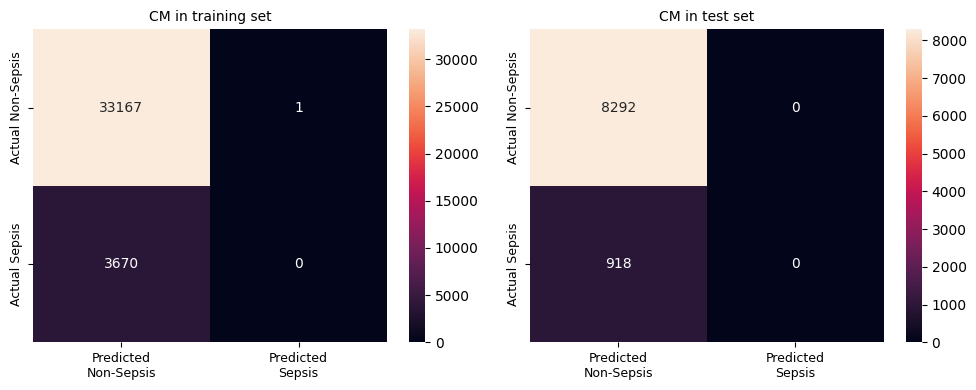


Precision: Training set 0.0000 ; Test set 0.0000
Recall: Training set 0.0000 ; Test set 0.0000
Predictive value of a negative test: Training set 0.9004 ; Test set 0.9003


/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
# Function for performance measures on (i) confusion matrix, (ii) precision, (iii) recall and (iv) NPV
def performance_measure(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Computating the confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    
    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])
    
    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()    

    # Computing precision and recall
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    print("\nPrecision: Training set {:.4f}".format(precision_train), "; Test set {:.4f}".format(precision_test))
    print("Recall: Training set {:.4f}".format(recall_train), "; Test set {:.4f}".format(recall_test))

     # Computing predictive values of a negative test
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
    NPV_train = tn_train / (tn_train + fn_train)
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
    NPV_test = tn_test / (tn_test + fn_test)
    print("Predictive value of a negative test: Training set {:.4f}".format(NPV_train), "; Test set {:.4f}".format(NPV_test))

print("Performance measures on Logistic Regression Classifier:\n")
performance_measure(t0_lr, X_t0_train, X_t0_test, y_t0_train, y_t0_test)

#### 4.1.1 Individual features - ITEM_ID 50912

In [93]:
feature_columns = t0_df.columns.drop("IS_SEPSIS").tolist()
target_column = ["IS_SEPSIS"]

# Convert numpy array back to DataFrame
X_t0_train_df = pd.DataFrame(X_t0_train, columns=feature_columns)
y_t0_train_df = pd.DataFrame(y_t0_train, columns=target_column)

X_t0_test_df = pd.DataFrame(X_t0_test, columns=feature_columns)
y_t0_test_df = pd.DataFrame(y_t0_test, columns=target_column)

# Extract specific feature for Logistic Regression
X_t0_train_50912 = X_t0_train_df["ITEMID_50912"].values.reshape(-1, 1)
y_t0_train_50912 = y_t0_train_df["IS_SEPSIS"]

X_t0_test_50912 = X_t0_test_df["ITEMID_50912"].values.reshape(-1, 1)
y_t0_test_50912 = y_t0_test_df["IS_SEPSIS"]

t0_lr.fit(X_t0_train_50912, y_t0_train_50912)

LogisticRegression(random_state=901)

In [94]:
# Estimated probabilities and decision boundary of "ITEM_ID 50912"
min_50912 = np.min(X_t0_train_df["ITEMID_50912"].values)
max_50912 = np.max(X_t0_train_df["ITEMID_50912"].values)

X_new_50912 = np.linspace(min_50912, max_50912, 1000).reshape(-1,1)
y_train_50912_proba = t0_lr.predict_proba(X_new_50912)

threshold_50912 = 0.5
decision_boundary_50912 = X_new_50912[y_train_50912_proba[:, 0] >= threshold_50912][0]
print("Decision boundary of ITEM_ID 50912 is {:.4f}".format(decision_boundary_50912[0]))

Decision boundary of ITEM_ID 50912 is 0.0000


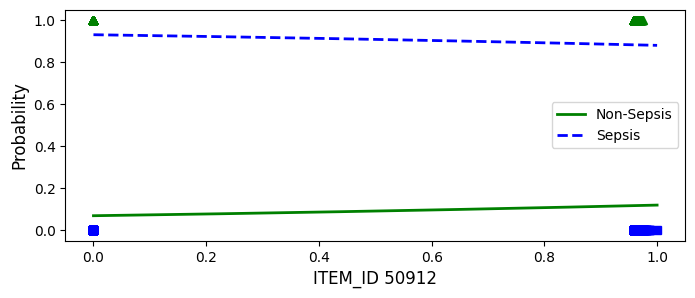

In [95]:
# Plotting the estimated probabilities and decision boundary
plt.figure(figsize=(8, 3))
plt.plot(X_t0_train_50912[y_t0_train_50912 == 0], y_t0_train_50912[y_t0_train_50912 == 0], "bs")
plt.plot(X_t0_train_50912[y_t0_train_50912 == 1], y_t0_train_50912[y_t0_train_50912 == 1], "g^")
#plt.plot([decision_boundary_50912, decision_boundary_50912], [-3, 3], "k:", linewidth=2)
plt.plot(X_new_50912, y_train_50912_proba[:, 1], "g-", linewidth = 2, label = "Non-Sepsis")
plt.plot(X_new_50912, y_train_50912_proba[:, 0], "b--", linewidth = 2, label = "Sepsis")
plt.xlabel("ITEM_ID 50912", fontsize = 12)
plt.ylabel("Probability", fontsize = 12)
plt.legend(loc = "center right", fontsize = 10)

plt.show()

### 4.2 Random Forest

In [96]:
# Define the RMSE scoring metric as a callable
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return sqrt(mse)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [97]:
t0_rf = RandomForestClassifier(random_state=901)
t0_rf.fit(X_t0_train, y_t0_train)


RandomForestClassifier(random_state=901)

In [98]:
# Predict the test set using the best random forest regressor
y_pred_rf = t0_rf.predict(X_t0_test)
y_pred_rf = np.round(y_pred_rf) # Round the predictions to the nearest integer

# Compute the RMSE of the predictions on the test set
rmse_rf = np.sqrt(mean_squared_error(y_t0_test, y_pred_rf))
print("Random Forest Classifier Test set RMSE: {:.4f}".format(rmse_rf))

Random Forest Classifier Test set RMSE: 0.3157


Performance measures on Random Forest Classifier:



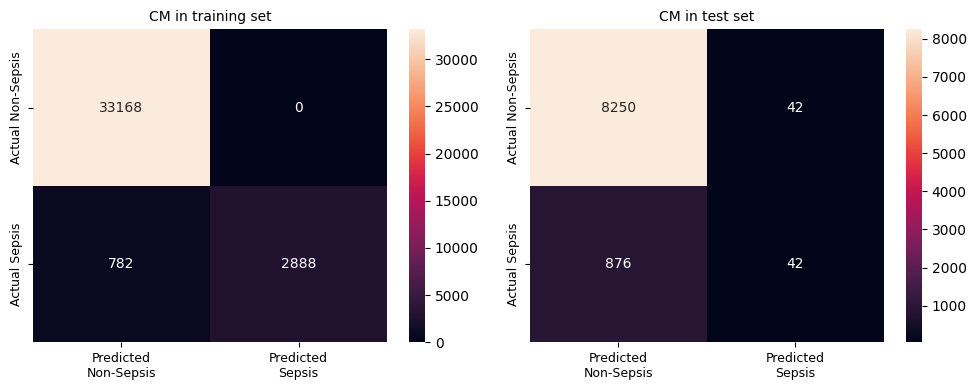


Precision: Training set 1.0000 ; Test set 0.5000
Recall: Training set 0.7869 ; Test set 0.0458
Predictive value of a negative test: Training set 0.9770 ; Test set 0.9040


In [99]:
print("Performance measures on Random Forest Classifier:\n")
performance_measure(t0_rf, X_t0_train, X_t0_test, y_t0_train, y_t0_test)

#### 4.2.1 Feature Selections

In [106]:
# Create a SelectFromModel object to remove features with importance values below 0.05
selector = SelectFromModel(t0_rf, threshold=0.05, prefit=True)

# Transform the training and test data to retain only the selected features
X_t0_train_reduced = selector.transform(X_t0_train)
X_t0_test_reduced = selector.transform(X_t0_test)

# Print the names of the retained features
feature_names = train_t0_df.columns[:-1][selector.get_support()]

importance_scores = t0_rf.feature_importances_[selector.get_support()]

# Combine feature names and their importance scores
feature_importance = list(zip(feature_names, importance_scores))

# Sort the features by importance score in descending order
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)

print('Selected features:')
for feature, score in sorted_features:
    print('{:15} Importance Score: {:.4f}'.format(feature, score))

# Print the total feature importance value that is retained after dimension reduction
total_importance = np.sum(t0_rf.feature_importances_[selector.get_support()])
print('\nTotal feature importance: {:.4f}'.format(total_importance))

Selected features:
ITEMID_51301    Importance Score: 0.1208
ITEMID_51244    Importance Score: 0.1021
ITEMID_51256    Importance Score: 0.1014
AGE             Importance Score: 0.0921
ITEMID_51279    Importance Score: 0.0863
ITEMID_51006    Importance Score: 0.0848
ITEMID_50912    Importance Score: 0.0845
ITEMID_50931    Importance Score: 0.0842
ITEMID_51221    Importance Score: 0.0823
ITEMID_51222    Importance Score: 0.0748
ITEMID_51274    Importance Score: 0.0716

Total feature importance: 0.9848
